https://www.kaggle.com/code/anonamename/g2net-oof-weight-optimizer?scriptVersionId=75557143

## This notebook forked from [Optimise Blending Weights with Bonus :0](https://www.kaggle.com/gogo827jz/optimise-blending-weights-with-bonus-0) by [Yirun Zhang](https://www.kaggle.com/gogo827jz).

In [1]:
import glob
import datetime
import pandas as pd
from time import time
from pathlib import Path
from pprint import pprint

import numpy as np
from scipy.optimize import minimize, fsolve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter

import plotly.figure_factory as ff
import plotly.express as px

sns.set_context("talk")
style.use('fivethirtyeight')
sns.set(font_scale=2.3, font='IPAexGothic')

import warnings
warnings.filterwarnings('ignore')

# open submission csv files

In [2]:
!ls ../input/g2net2-csv

3090_kqi_ex009_fold01234_seresnext101d_wd1e-5_lr-r1e-2_s-mixup05_ep50_oof_df_seed0.csv
3090_kqi_ex009_fold01234_seresnext101d_wd1e-5_lr-r1e-2_s-mixup05_ep50_submission.csv
3090_kqi_ex011_fold01234_b4_ap_oof_df_seed0.csv
3090_kqi_ex011_fold01234_b4_ap_submission.csv
3090_kqi_ex022_zip_dataset_resize_seresnext101d_oof_df_seed0.csv
3090_kqi_ex022_zip_dataset_resize_seresnext101d_submission.csv
3090_kqi_ex027_fold01234_b4_ap_prob_mean_mixup03_oof_df_seed0.csv
3090_kqi_ex027_fold01234_b4_ap_prob_mean_mixup03_submission.csv
3090_kqi_ex029_fold01234_b4_ap_prob_mean_mixup05_ma_norm_oof_df_seed0.csv
3090_kqi_ex029_fold01234_b4_ap_prob_mean_mixup05_ma_norm_submission.csv
3090_kqi_ex037_fold01234_b4_ap_swap_ch_nega-flip_nega_oof_df_seed0.csv
3090_kqi_ex037_fold01234_b4_ap_swap_ch_nega-flip_nega_submission.csv
3090_kqi_ex051_add_ex003_noise_01_gap_fold01234_b4_ap_oof_df_seed0.csv
3090_kqi_ex051_add_ex003_noise_01_gap_fold01234_b4_ap_submission.csv
3090_kqi_ex057_npy_add_ex003_01_fold01234_b4_ap_oo

In [3]:
submit = pd.read_csv("../input/g2net-detecting-continuous-gravitational-waves/sample_submission.csv")

SUB_DIR = "../input/g2net2-csv"
sub_dict = {
    #"ex027_b4_ap": SUB_DIR + "/3090_kqi_ex027_fold01234_b4_ap_prob_mean_mixup03_submission.csv",
    #"lb0685_owo_v5_sub_avg": SUB_DIR + "/lb0685_g2net2_oof_weight_optimizer_v5_sub_avg.csv",
    
    #"lb07_owo_v8_sub_opt_auc": SUB_DIR + "/lb0.7_g2net2_oof_weight_optimizer_v8_sub_ws_norm_opt_auc.csv",  # lb0.7
    #"ex051_add_ex003_noise_01": SUB_DIR + "/3090_kqi_ex051_add_ex003_noise_01_gap_fold01234_b4_ap_submission.csv",  # lb0.707
    #"ex057_add_ex003_noise_01": SUB_DIR + "/3090_kqi_ex057_npy_add_ex003_01_fold01234_b4_ap_submission.csv",  # lb0.709
    
    #"lb0748_public": SUB_DIR + "/g2net-large-kernel-inference/lb0748_submission.csv",
    #"ex063_add_ex003_2-005-01_005iso-01": SUB_DIR + "/kqi_3090_ex063_npy_add_ex003_2-005-01_005iso-01_fold01234_b4_ap_noamp_submission.csv",  # 0.739
    #"blend_add_ex003_01-005_005iso": SUB_DIR + "/lb0738_g2net2_oof_weight_optimizer_v9_sub_avg.csv",  # 0.738
    
    #"lb0748_public": SUB_DIR + "/g2net-large-kernel-inference/lb0748_submission.csv",
    #"ex066_lb0743": SUB_DIR + "/3090_kqi_ex066_public_add_ex006-n1400-s800_fold01234_b4_ap_largekernel_p-robustscaler_ts-ma_submission.csv",  # 0.743
    #"ex066_lb0744": SUB_DIR + "/3090_kqi_ex066_public_add_ex003_2-005-01_005iso-01_006_fold01234_b5_ap_ts-ma_p-robustscaler_submission.csv",  # 0.744
    #"ex066_lb0747": SUB_DIR + "/3090_kqi_ex066_public_add_ex003_2-005-01_005iso-01_006_fold01234_b5_ap_largekernel_p-robustscaler_ts-ma_submission.csv",  # 0.747
    
    #"ex067_pseudo_lb0751": SUB_DIR + "/3090_kqi_ex067_pseudo_add_ex003_2-005-01_005iso-01_006_fold01234_b5_ap_submission.csv",
    
    #"sub_avg_lb0761": SUB_DIR + "/sub_avg_lb0761.csv",
    #"sub_ws_norm_opt_auc_lb0755": SUB_DIR + "/sub_ws_norm_opt_auc_lb0755.csv",
    #"ex073_b4_ap_lb0759": SUB_DIR + "/kqi_3090_ex073_pseudo_add_ex003_2-005-01_005iso-01_006_b4_ap_n_fold20_submission.csv",
    #"ex073_b5_ap": SUB_DIR + "/3090_kqi_ex073_pseudo_add_ex003_2-005-01_005iso-01_006_b5_ap_n_fold20_submission.csv",
    
    #"lb0768_kqi_ex075_v2_n50": SUB_DIR + "/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50_submission.csv",
    #"lb0765_ex081_lb0768pseudo": SUB_DIR + "/3090_kqi_ex081_pseudo_multioutput_freq_b5_ap_submission.csv",
    ##"lb0763_ex078_10fold": SUB_DIR + "/kqi_3090_ex078_pseudo_multioutput_freq_b5_ap_10fold_submission.csv",
    ##"lb0763_ex075_n25": SUB_DIR + "/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n25_submission.csv",
    ##"lb0762_ex075_mixup_use_pseudo_f": SUB_DIR + "/3090_kqi_ex075_v2_pseudo_multioutput_freq_b5_ap_mixup_use_pseudo_f_submission.csv",
    ##"lb0761_ex075_20fold": SUB_DIR + "/kqi_3090_ex075_pseudo_multioutput_freq_b5_ap_20fold_submission.csv",
    #"lb0761_g2net2_sub_avg_v12": SUB_DIR + "/lb0.761_g2net2_sub_avg_v12_sub_avg.csv",
    #"lb0759_ex082_rsch": SUB_DIR + "/3090_kqi_ex082_pseudo_multioutput_freq_rsch_b5_submission.csv",
    #"lb0759_ex080_freq_sample_mixup": SUB_DIR + "/3090_kqi_ex080_pseudo_multioutput_freq_b5_ap_submission.csv",
    ##"lb0759_ex073_b4_ap_20fold": SUB_DIR + "/kqi_3090_ex073_pseudo_add_ex003_2-005-01_005iso-01_006_b4_ap_n_fold20_submission.csv",
    ##"lb0758_ex077_add_ex008": SUB_DIR + "/3090_kqi_ex077_pseudo_b6_ap_Drop_add_Ex3-5-6-8_add_pseudo_EX7_1800_fold20_submission.csv",
    #"lb0758_ex078_hstack_2ch": SUB_DIR + "/kqi_3090_ex078_pseudo_multioutput_freq_b5_ap_hstack_2ch_submission.csv",
    #"ex078_vstack_2ch": SUB_DIR + "/kqi_3090_ex078_pseudo_multioutput_freq_b5_ap_vstack_2ch_submission.csv",
    ##"lb0754_ex083_multioutput2": SUB_DIR + "/3090_kqi_ex083_pseudo_multioutput2_b5_submission.csv",
    #"lb0754_ex088_gap_flg_ch05": SUB_DIR + "/3090_kqi_ex088_pseudo_multioutput_b5_gap_flg_ch05_submission.csv",
    #"lb0753_ex075_gap_flg_ch00": SUB_DIR + "/3090_kqi_ex075_v5_gap_flg_ch00_submission.csv",
    ##"lb0753_ex076_addemb": SUB_DIR + "/kqi_3090_ex076_pseudo_addemb_freq_b5_ap_submission.csv",
    
    #"lb0771_kqi_ex075_v2_n50_tta02": SUB_DIR + "/lb0.771_kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50_submission_tta012.csv",
    #"lb0767_kqi_ex075_v12": SUB_DIR + "/3090_kqi_ex075_v12_pseudo_kqi_ex075_v6_load_kqi_ex075_v11_ep50_submission.csv",
    #"sub_avg_lb0771": SUB_DIR + "/sub_avg_lb0771.csv",
    #"lb0772_kqi_ex075_v2_hvflip_lb0771_09501_sim0000_tta02": SUB_DIR + "/lb0.772_kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000_submission.csv"
    
    #"lb0769_3090_ex075_v21_zebra": SUB_DIR + "/3090_kqi_ex075_v21_zebra_mixup05_sample_mixup05_load_kqi_3090_ex075_v11_best_score_submission.csv",
    
    #"lb0773_kqi_ex075_v2": SUB_DIR + "/lb0.773_kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_1000_sim0000_submission.csv",
    
    #"lb0774_kqi_ex075_v2": SUB_DIR + "/lb0.774_kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_submission.csv",
    
    #"lb0775_kqi_ex075_v2_stride12": SUB_DIR + "/lb0.775_kqi_3090_ex075_v2_tta_v3_pseudo_v3_hvflip_stride12_lb0771_1000_simall_100ep_submission_tta012.csv",
    
    #"lb0773_kqi_ex075_v2_no_norm": SUB_DIR + "/3090_kqi_ex075_v2_tta_v4_no_norm_hvflip_lb0771_pseudo_th_5_10_100ep_submission_tta012.csv",
    
    #"lb0775_kqi_ex075_v2_stride12_no_norm": SUB_DIR + "/kqi_3090_ex075_v2_tta_v4_no_norm_hvflip_stride12_lb0775_pseudo_th_5_10_100ep_submission_tta012.csv",
    
    #"lb0775_kqi_ex075_v2_norm_5_10": SUB_DIR + "/lb0.775_kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_submission_tta012.csv",
    
    #"lb0776_kqi_ex075_v2_stride12_norm_5_10_addD_EX007": SUB_DIR + "/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_submission_tta012.csv",
    
    #"sub_rank_ver30_lb0778": SUB_DIR + "/sub_rank_ver30_lb0778.csv",
    #"sub_avg_ver30_lb0778": SUB_DIR + "/sub_avg_ver30_lb0778.csv",
    
    #"lb0778_kqi_ex075_v2_stride12_norm_5_10_addD_EX007_2": SUB_DIR + "/lb0.778_3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_submission_tta012.csv",
    
    #"sub_rank_ver32_lb0780": SUB_DIR + "/sub_rank_ver32_lb0780.csv",
    #"sub_rank_ver34_lb0780": SUB_DIR + "/sub_rank_ver34_lb0780.csv",
    
    #"lb0.779_kqi_3090_ex075_GaussNoise_tta0128": SUB_DIR + "/lb0.779_kqi_3090_ex075_GaussNoise_submission_tta0128.csv",
    
    #"lb0.780_kqi_3090_ex075_GaussNoise_tta0128": SUB_DIR + "/lb0.780_kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_submission_tta012.csv",
    
    
    #"GeM2f_stride12_norm": SUB_DIR + "/3090_kqi_ex075_v2_stride12_GeM2f_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_submission_tta012.csv",
    #"GeM2f_stride12_simall": SUB_DIR + "/kqi_3090_ex075_v2_stride12_GeM2f_norm_lb0771_pseudo_simall_addD_EX007_3_GN_submission_tta012.csv",
    #"AndCh_stride12_norm": SUB_DIR + "/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_AndCh_submission_tta012.csv",
    #"stride12_norm": SUB_DIR + "/lb0.780_kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_submission_tta012.csv",
    #"stride12_simall": SUB_DIR + "/kqi_3090_ex075_v2_stride12_lb0771_pseudo_simall_addD_EX007_3_GN_submission_tta012.csv",
    
    "sub_rank_ver35_lb0781": SUB_DIR + "/sub_rank_ver35_lb0781.csv",
    "sub_rank_ver37_lb0.780": SUB_DIR + "/sub_rank_ver37_lb0.780.csv",
}
pprint(sub_dict)

subs = np.zeros((len(sub_dict), submit.shape[0], len(['target']) ))
for i, p in enumerate(sub_dict.keys()):
    sub = pd.read_csv( list(sub_dict.values())[i] )
    subs[i] = sub[['target']].values
display(pd.DataFrame(subs.reshape(subs.shape[0], 7975).T, columns=sub_dict.keys()))
subs

{'sub_rank_ver35_lb0781': '../input/g2net2-csv/sub_rank_ver35_lb0781.csv',
 'sub_rank_ver37_lb0.780': '../input/g2net2-csv/sub_rank_ver37_lb0.780.csv'}


,sub_rank_ver35_lb0781,sub_rank_ver37_lb0.780
0,0.370721,0.538934
1,0.713292,0.734169
2,0.270282,0.376301
3,0.766082,0.762759
4,0.769279,0.772602
...,...,...
7970,0.840846,0.843574
7971,0.268245,0.262571
7972,0.240909,0.376426
7973,0.378307,0.452476


array([[[0.370721  ],
        [0.71329154],
        [0.27028213],
        ...,
        [0.24090909],
        [0.37830721],
        [0.19554859]],

       [[0.53893417],
        [0.73416928],
        [0.37630094],
        ...,
        [0.37642633],
        [0.45247649],
        [0.1061442 ]]])

0 sub_rank_ver35_lb0781
1 sub_rank_ver37_lb0.780


Text(0.5, 1.0, 'SUB correlation')

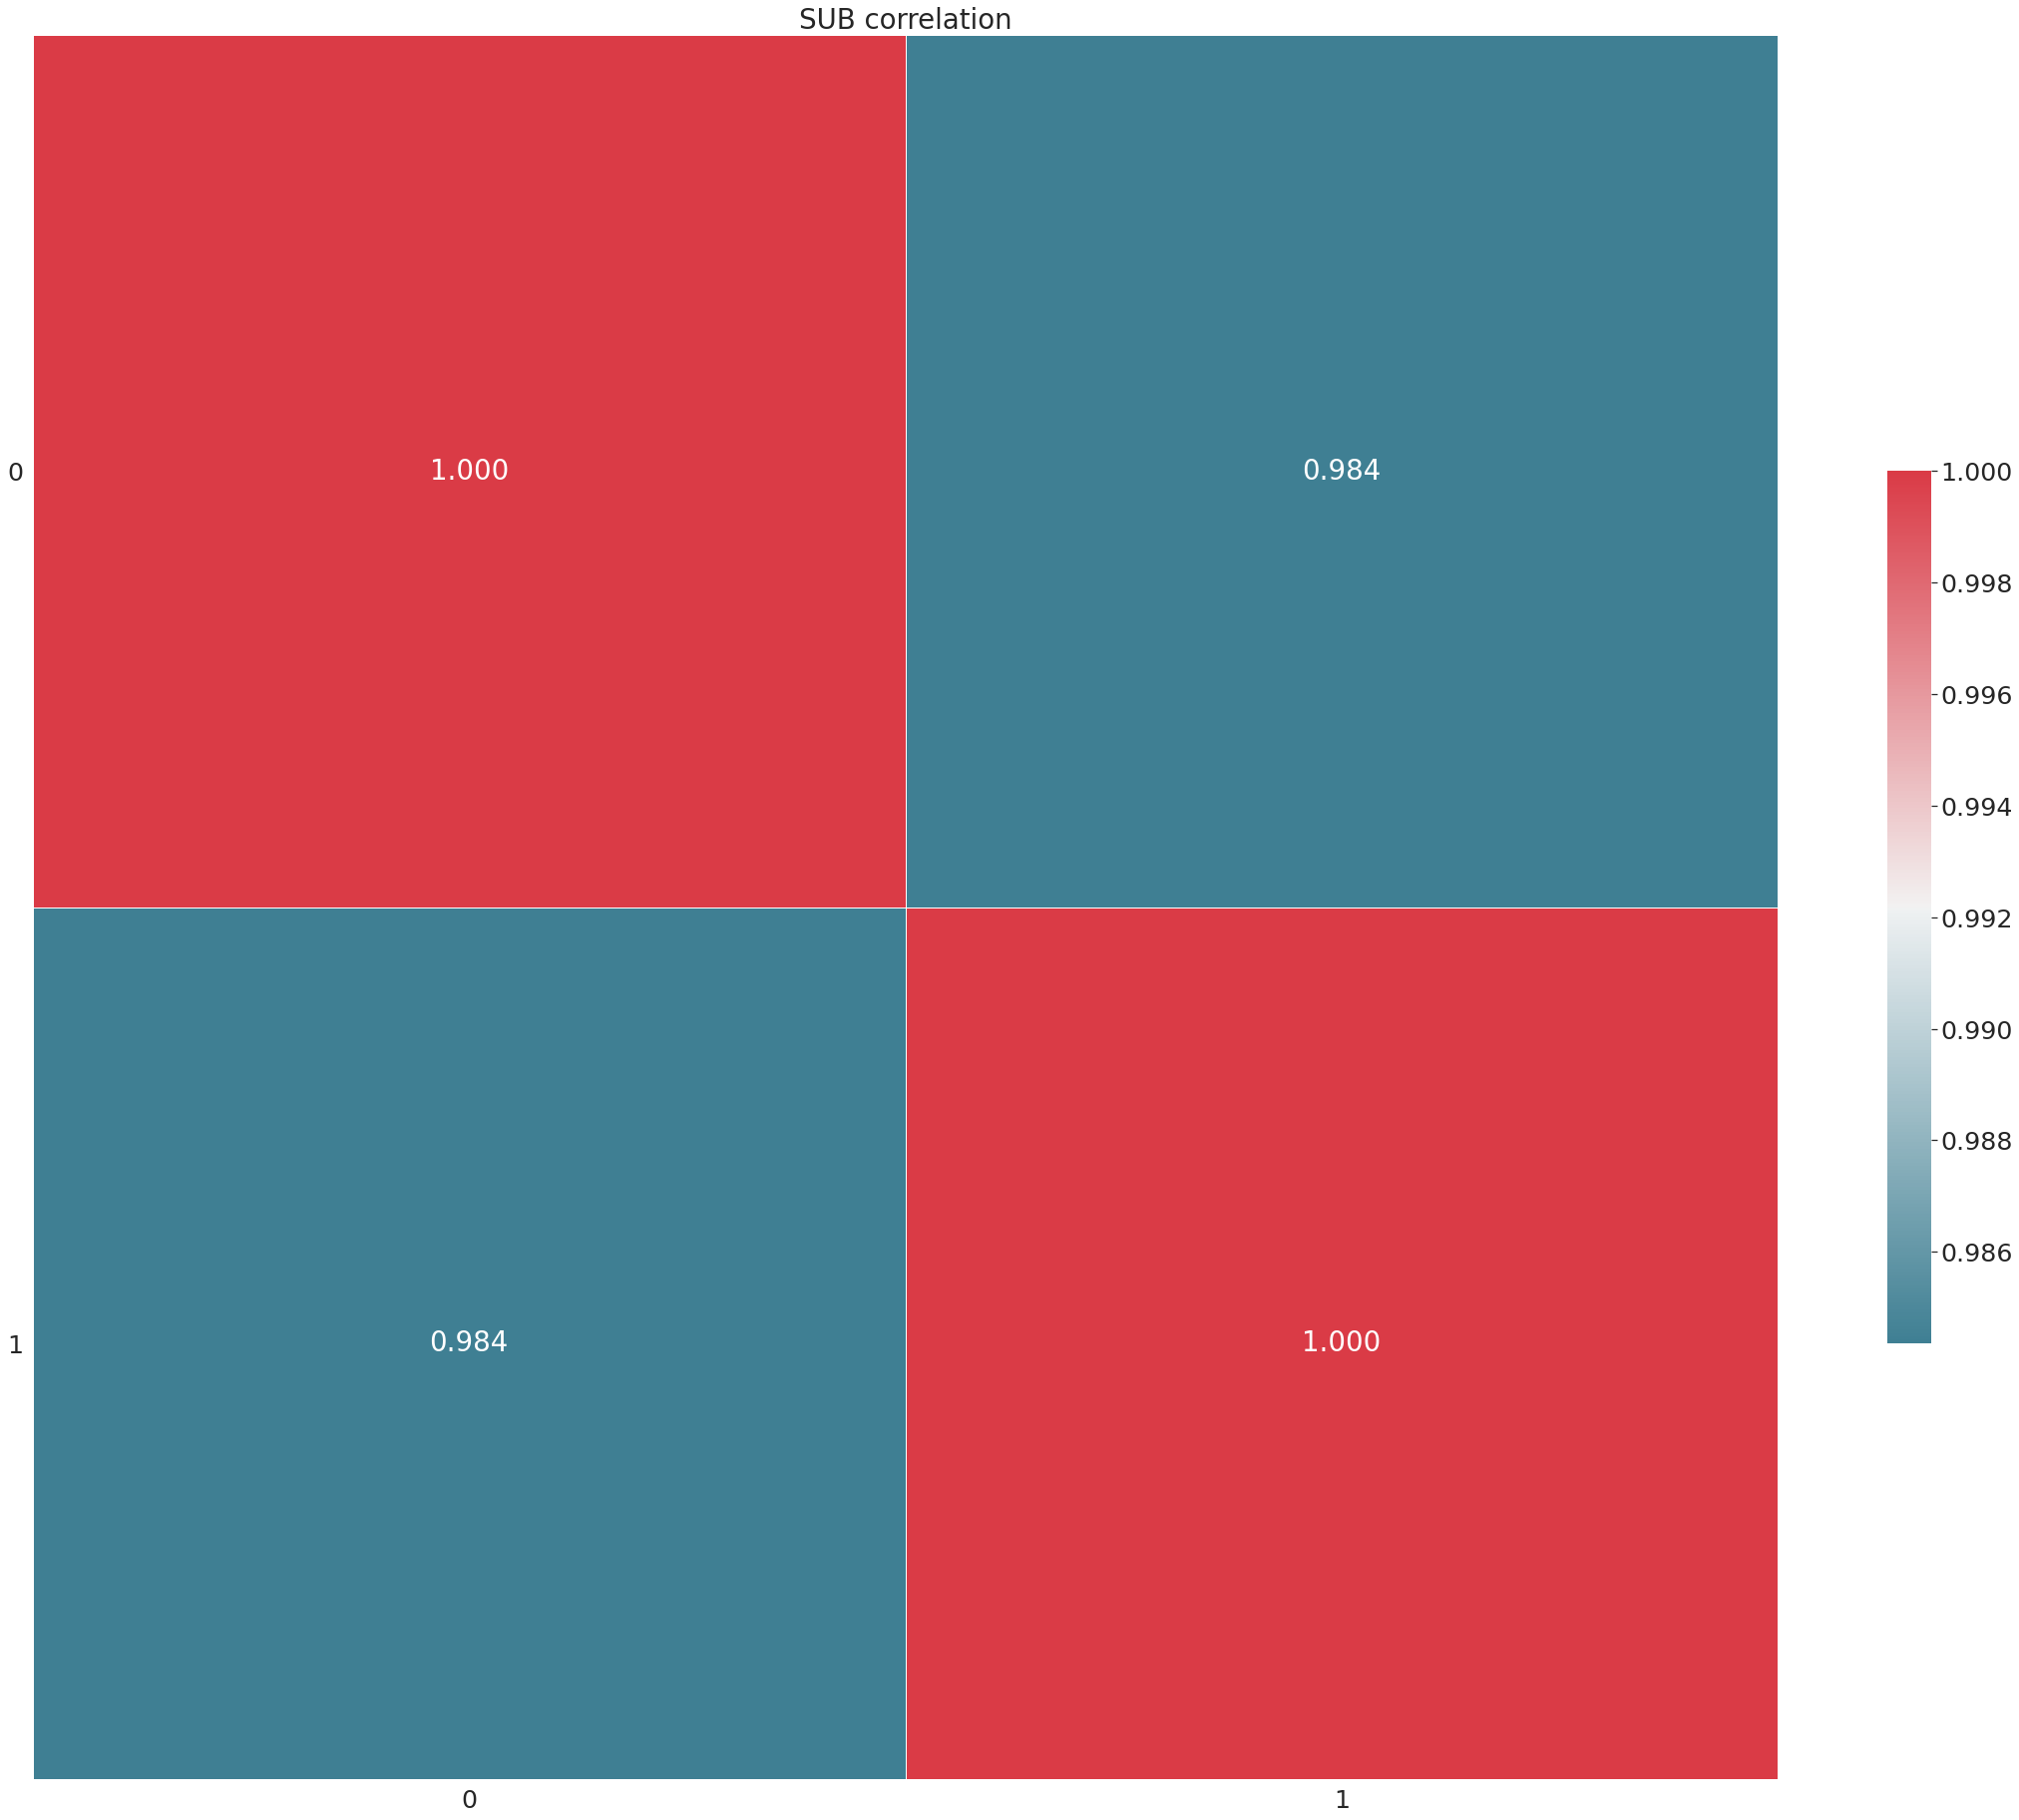

In [4]:

target_columns  = ['target']

sub_targets_scored = pd.read_csv( list(sub_dict.values())[0] )

sub_v2 = np.zeros((len(sub_dict), submit.shape[0], len(target_columns) ))

for i, p in enumerate(sub_dict.keys()):
    print(i,p)
    tmp = pd.read_csv(sub_dict[p])
    sub = sub_targets_scored.drop(columns=target_columns).merge(tmp[['id']+target_columns], on='id', how='left')
    sub_v2[i,:,:] = sub[target_columns].values 

corr = np.corrcoef(sub_v2.reshape(len(sub_dict), -1))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(35, 30))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, annot=True, fmt='.3f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
ax.set_ylim(corr.shape[0], 0)
plt.yticks(rotation=0)
plt.title("SUB correlation")

OUTPUT: sub_avg.csv


,id,target
0,00054c878,0.454828
1,0007285a3,0.723730
2,00076c5a6,0.323292
3,001349290,0.764420
4,001a52e92,0.770940
...,...,...
7970,ffbce04ef,0.842210
7971,ffc2d976b,0.265408
7972,ffc905909,0.308668
7973,ffe276f3e,0.415392


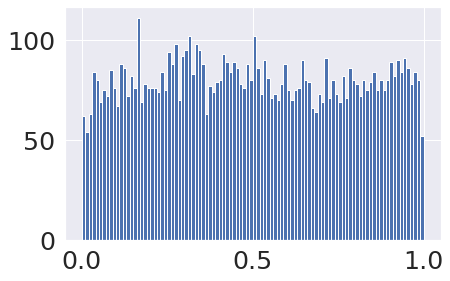

In [5]:

sub_avg = np.zeros((submit.shape[0], ))
for i, s in enumerate(subs):
    s_ws = s * 1.0 / len(subs)
    sub_avg += s_ws.ravel()

sub_avg_df = pd.DataFrame({"id": submit.id, "target": sub_avg})
sub_avg_df.to_csv(f'sub_avg.csv', index=False)
print("OUTPUT: sub_avg.csv")
display(sub_avg_df)

plt.hist(sub_avg_df["target"], bins=100)
plt.show()
plt.clf()
plt.close()

In [6]:

#ws = [0.748, 0.773]
#sub_avg = np.zeros((submit.shape[0], ))
#for s, w in zip(subs, ws):
#    s_ws = s * w / sum(ws)
#    sub_avg += s_ws.ravel()
#
#sub_avg_df = pd.DataFrame({"id": submit.id, "target": sub_avg})
#sub_avg_df.to_csv(f'sub_w_avg.csv', index=False)
#print("OUTPUT: sub_w_avg.csv")
#display(sub_avg_df)
#
#plt.hist(sub_avg_df["target"], bins=100)
#plt.show()
#plt.clf()
#plt.close()

In [7]:

fig = ff.create_distplot([s.ravel() for s in subs], list(sub_dict.keys()), bin_size=.2, show_hist=False, show_rug=False)
fig.show()

# Rank Averaging from [tips: rank averaging](https://www.kaggle.com/c/ranzcr-clip-catheter-line-classification/discussion/205564) by [Tawara](https://www.kaggle.com/ttahara).

In [8]:
from scipy.stats import rankdata

{'sub_rank_ver35_lb0781': '../input/g2net2-csv/sub_rank_ver35_lb0781.csv',
 'sub_rank_ver37_lb0.780': '../input/g2net2-csv/sub_rank_ver37_lb0.780.csv'}
OUTPUT: sub_rank.csv


,id,target
0,00054c878,0.460188
1,0007285a3,0.725643
2,00076c5a6,0.321944
3,001349290,0.764483
4,001a52e92,0.771536
...,...,...
7970,ffbce04ef,0.841505
7971,ffc2d976b,0.260596
7972,ffc905909,0.305893
7973,ffe276f3e,0.419342


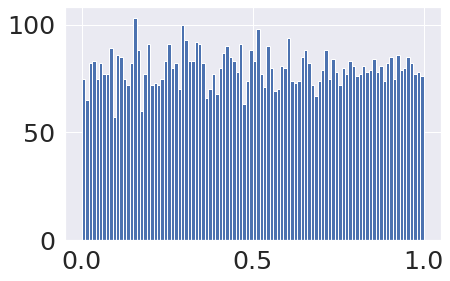

In [9]:

pprint(sub_dict)

target_columns = ["target"]
sub_rank = np.zeros((len(sub_dict), submit.shape[0], len(target_columns) ))
for i in range(sub_rank.shape[0]):
    sub = pd.read_csv( list(sub_dict.values())[i] )
    sub = submit.drop(columns=target_columns).merge(sub[['id']+target_columns], on='id', how='left')
    sub_rank[i] = sub[target_columns].values

for i in range(sub_rank.shape[0]):
    for j in range(len(target_columns)):
        sub_rank[i,:,j] = rankdata(sub_rank[i,:,j],method='average')

sub_rank = np.mean(sub_rank, axis=0)/np.max(sub_rank)
#print(sub_rank)

sub_rank_df = pd.DataFrame({"id": submit.id, "target": sub_rank.ravel()})
sub_rank_df.to_csv(f'sub_rank.csv', index=False)
print("OUTPUT: sub_rank.csv")
display(sub_rank_df)

plt.hist(sub_rank_df["target"], bins=100)
plt.show()
plt.clf()
plt.close()